In [39]:
import scipy.io
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [35]:
components = scipy.io.loadmat('auditory_brain_dnn/data/neural/NH2015comp/components.mat')
ytrue = components['R']
stim_names = components['stim_names']

x = []
for s in stim_names[0]:
    s_data = []
    filename = f'auditory_brain_dnn/model_actv/mel256-ec-base/{s[0]}_activations.pkl'
    with open(filename,'rb') as f:
        act_data = pickle.load(f)
        for i in range(10):
            s_data.append(act_data[i])
    x.append(s_data)
x = np.array(x)

In [76]:
n_train=83
N_CV=10
all_test_r2 = []
for layer in range(10):
    test_r2 = []
    models = []
    for i in tqdm(range(N_CV)):
        idxs = np.random.permutation(np.arange(len(ytrue)))
        train_idxs = idxs[:n_train]
        test_idxs = idxs[n_train:]
        x_train = x[train_idxs, layer]
        x_test = x[test_idxs, layer]
        y_train = ytrue[train_idxs]
        y_test = ytrue[test_idxs]
        
        possible_alphas = [10 ** x for x in range(-50, 50)]
        model = RidgeCV(possible_alphas, store_cv_results=True)
        scaler_x = StandardScaler(with_std=False)
        scaler_y = StandardScaler(with_std=False)
        x_train = scaler_x.fit_transform(x_train)
        x_test = scaler_x.transform(x_test)
        y_train = scaler_y.fit_transform(y_train)
        model.fit(x_train, y_train)
        yhat_test = model.predict(x_test)
        yhat_test = yhat_test + scaler_y.mean_
        test_r2.append(r2_score(y_test, yhat_test, multioutput='raw_values'))
        models.append(model)
    test_r2 = np.array(test_r2)
    all_test_r2.append(test_r2)
all_test_r2 = np.array(all_test_r2)
median_test_r2 = np.median(all_test_r2,axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 270.77it/s]


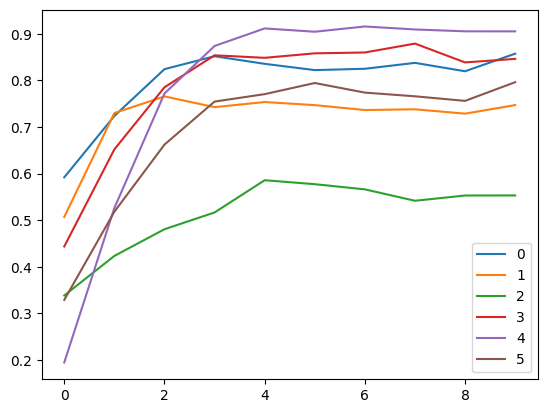

In [83]:
for c in range(6):
    plt.plot(median_test_r2[:,c], label=c)
plt.legend()

In [55]:
from sklearn.metrics import r2_score